# Exploring MNE's data structure
---

## Learning Objectives
- Import raw EEG data using MNE
- Examine the structure of an MNE `Raw` object
- Access and view different attributes of a `Raw` data object
- Visualize the positions of EEG electrodes 


---
## Introduction

In this lesson, we will load a raw EEG data file using MNE and gain an understanding of how MNE stores data. This is an important first step to working with data in MNE.


## Load pacakges

~~~python
import mne
mne.set_log_level('error')

import numpy as np
import matplotlib.pyplot as plt
import glob
~~~

In [1]:
# Needed to install mne first
!pip install mne

import mne
mne.set_log_level('error')

import numpy as np
import matplotlib.pyplot as plt
import glob


## Import raw data

For EEG, raw data is typically stored in a single file containing continuous EEG data. There are many different file formats for EEG data; most of these are developed by the manufacturer of a particular EEG system. Fortunately, MNE provides functions to import data from most common EEG systems. 

In the present case, we are working with data from a system sold by Brain Products, whose software is called *Brain Vision*. So we will use MNE's `read_raw_brainvision()` function. The Brain Vision format actually specifies *three files* for any given data set, as we can see if we look for all the file names in the `data` subfolder that start with the subject ID code for our data set, `P4`:

~~~python
glob.glob('data/N400_dataset_04*')
~~~

In [2]:
glob.glob("data/N400_dataset_04*")

[]

The three files are all created at the time that the EEG data is acquired, and it's important to ensure that all three are copied when moving them around. The files are as follows:
- `*.eeg` is the actual EEG data (electrical potential measurements for all electrodes, at all time points). This is stored in a compressed (binary) format
- `*.vmrk` is a text file containing all of the markers (*trigger codes*) that were sent to the EEG system during data collection, by the stimulus computer. These typically encode the onset of various stimuli, and times of any responses by the participant, as well as what each stimulus/response was. 
- `*.vhdr` is a text file with header information, or **metadata** about the data set, including technical details such as the sampling rate, and the settings of the EEG amplifier during the recording. The `.vhdr` file is particularly important because it specifies the file names of the `.eeg` and `.trg` files (although they should always be named consistently with the header file). 

When we run `read_raw_brainvision()` the file we will actually pass as an argument is the `.vhdr` file. Since it specifies the names of the associated `.eeg` and `.trg` files, from this file MNE can find the data and markers.

As described previously, many of MNE's functions are nested inside subfolders (modules); for example, all of the file input-output (I/O) routines are in the module `mne.io`. So when we call the `read_raw_brainvision()` function, we have to do so as `mne.io.read_raw_brainvision()`. The one required argument for this function is the file name, and that's all we need for now: 

~~~python
raw = mne.io.read_raw_brainvision('data/N400_dataset_04.vhdr')
~~~

In [4]:
# Has to install the data from GitHub
raw = mne.io.read_raw_brainvision("data/sub-001/sub-001.vhdr")

<div class="alert alert-block alert-info">

At the start of the lesson, we ran a command after importing mne, `mne.set_log_level('error')`. If you don't run this when using MNE, you will find that MNE provides a lot output, often including some concerning-looking Python warning messages. Most of these warnings are safely ignored. I generally find this output more confusing than helpful, and turn it off routinely. For our lessons we will keep the output off because it just creates confusion.
    </div>

### View raw data attributes

We now have our raw EEG data represented in Python as an MNE `Raw` object. We can view it's basic information by asking for the `.info` property:

~~~python
raw.info
~~~

In [5]:
raw.info

Measurement date,"January 20, 2015 13:15:58 GMT"
Experimenter,Unknown
Participant,Unknown
Digitized points,Not available
Good channels,16 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,500.00 Hz
Highpass,0.01 Hz
Lowpass,80.00 Hz


Although some of the information is not available, this shows us a few important things about our data set, including that there are 16 EEG channels (each channel contains the data from one EEG electrode), that the sampling rate is 500 Hz (i.e., EEG data were sampled 500 times per second, so we have a data point every 2 ms), and that the data were filtered during data collection between 0.01–80 Hz (more on filtering below).

The information provided above is actually a subset of the information stored in the `Raw` object's `info`. We can use the `.keys()` method to see all of the fields available in `info`:

~~~python
raw.info.keys()
~~~

In [6]:
raw.info.keys()

dict_keys(['acq_pars', 'acq_stim', 'ctf_head_t', 'description', 'dev_ctf_t', 'dig', 'experimenter', 'utc_offset', 'device_info', 'file_id', 'highpass', 'hpi_subsystem', 'kit_system_id', 'helium_info', 'line_freq', 'lowpass', 'meas_date', 'meas_id', 'proj_id', 'proj_name', 'subject_info', 'xplotter_layout', 'gantry_angle', 'bads', 'chs', 'comps', 'events', 'hpi_meas', 'hpi_results', 'projs', 'proc_history', 'custom_ref_applied', 'sfreq', 'dev_head_t', 'ch_names', 'nchan'])

We can access the values stored with any of these info attributes by putting it in square brackets, like this command to access the names of all of the channels (electrodes) in the data set:

~~~python
raw.info['ch_names']
~~~

In [7]:
raw.info["ch_names"]

['Fp1',
 'F3',
 'F7',
 'C3',
 'P3',
 'TP9',
 'Fz',
 'Cz',
 'Fp2',
 'F4',
 'F8',
 'C4',
 'P4',
 'TP10',
 'Pz',
 'Oz']

The `info` is a snapshot of a few pieces of information that researchers may want to know about a data file, but it's far less than all the information stored in the MNE `Raw` object. To see the entire contents of the object, we can ask for it's `__dict__` (note that there are two underscores below `dict` and two after). Recall that `Raw` is a Python class, and any instance of the `Raw` class (such as our `raw` data here) is a Python object. Any Python object has an atrribute `__dict__`, and this attribute contains a dictionary of all of the object's attributes, with keys being the attribute names, and values being the information stored for that attribute.

~~~python
raw.__dict__
~~~

In [8]:
raw.__dict__

{'preload': False,
 '_last_samps': array([408639]),
 '_first_samps': array([0]),
 'info': <Info | 7 non-empty values
  bads: []
  ch_names: Fp1, F3, F7, C3, P3, TP9, Fz, Cz, Fp2, F4, F8, C4, P4, TP10, Pz, Oz
  chs: 16 EEG
  custom_ref_applied: False
  highpass: 0.0 Hz
  lowpass: 80.0 Hz
  meas_date: 2015-01-20 13:15:58 UTC
  nchan: 16
  projs: []
  sfreq: 500.0 Hz
 >,
 'buffer_size_sec': 1.0,
 '_cals': array([4.88281e-08, 4.88281e-08, 4.88281e-08, 4.88281e-08, 4.88281e-08,
        4.88281e-08, 4.88281e-08, 4.88281e-08, 4.88281e-08, 4.88281e-08,
        4.88281e-08, 4.88281e-08, 4.88281e-08, 4.88281e-08, 4.88281e-08,
        4.88281e-08]),
 '_raw_extras': [{'offsets': None,
   'fmt': 'single',
   'order': 'F',
   'n_samples': 408640,
   'orig_nchan': 16}],
 '_read_picks': [array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])],
 '_read_comp_grade': None,
 '_comp': None,
 '_filenames': ['/Users/freddy/github/Chapter-7--EEG/data/sub-001/sub-001.eeg'],
 'orig_format': 'si

## Where's the data?

For all the information that is in the output above, one thing you may have noticed is that there doesn't seem to be any actual EEG data! This is because, by default, MNE's routines to read raw data read the data file's *header* into memory, but not the data itself. The reason for this is that data files are often quite large, and so reading them in sometimes takes a noticeable amount of time, and consume significant memory. The header of a raw EEG data file contains its metadata (information about the file), as you saw above in printing out the `__dict__` this is often enough for MNE to perform some operations on the data. At some point, if you want to perform operations on the EEG data, then MNE will automatically load in the data to work on it. 

We can force MNE to load in the data when we read the file, with the `preload` kwarg. We'll do this now so that we can look at the data:

~~~python
raw = mne.io.read_raw_brainvision('data/N400_dataset_04.vhdr', 
                                    preload=True)
raw.__dict__
~~~

In [16]:
raw = mne.io.read_raw_brainvision('data//sub-001/sub-001.vhdr', 
                                    preload=True)
raw.__dict__

{'_last_samps': array([408639]),
 '_first_samps': array([0]),
 'info': <Info | 7 non-empty values
  bads: []
  ch_names: Fp1, F3, F7, C3, P3, TP9, Fz, Cz, Fp2, F4, F8, C4, P4, TP10, Pz, Oz
  chs: 16 EEG
  custom_ref_applied: False
  highpass: 0.0 Hz
  lowpass: 80.0 Hz
  meas_date: 2015-01-20 13:15:58 UTC
  nchan: 16
  projs: []
  sfreq: 500.0 Hz
 >,
 'buffer_size_sec': 1.0,
 '_cals': array([4.88281e-08, 4.88281e-08, 4.88281e-08, 4.88281e-08, 4.88281e-08,
        4.88281e-08, 4.88281e-08, 4.88281e-08, 4.88281e-08, 4.88281e-08,
        4.88281e-08, 4.88281e-08, 4.88281e-08, 4.88281e-08, 4.88281e-08,
        4.88281e-08]),
 '_raw_extras': [{'offsets': None,
   'fmt': 'single',
   'order': 'F',
   'n_samples': 408640,
   'orig_nchan': 16}],
 '_read_picks': [array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])],
 '_read_comp_grade': None,
 '_comp': None,
 '_filenames': ['/Users/freddy/github/Chapter-7--EEG/data/sub-001/sub-001.eeg'],
 'orig_format': 'single',
 '_orig_unit

Now we can see that there is a `_data` attribute, containing a NumPy array. We can access the data like so:

~~~python
print(type(raw._data))
print(raw._data.shape)
~~~

In [17]:
print(type(raw._data))
print(raw._data.shape)

<class 'numpy.ndarray'>
(16, 408640)


MNE represents the data as a 2D array with a row for each channel, and columns for time points. We can derive the length of the EEG recording, in seconds, by dividing the number of time points by the sampling rate:

In [18]:
raw.info["sfreq"]

500.0

~~~python
scan_durn = raw._data.shape[1] / raw.info['sfreq']
print('Duration of EEG recording = ', scan_durn, 's, or', scan_durn / 60, 'min.')
~~~

In [19]:
scan_durn = raw._data.shape[1] / raw.info["sfreq"]
print("Duration of EEG recording = ", scan_durn, "s, or", round(scan_durn / 60, 2), "min.")

Duration of EEG recording =  817.28 s, or 13.62 min.


## Accessing subsets of data

Since the data is stored as a NumPy array, we can access specific data points using standard indexing. For example, if we wanted to select all of the data from only channel 15, we would use:

~~~python
print(raw._data[15, :])
~~~

In [20]:
print(raw._data[15, :])

[-3.00623740e-05 -3.05631481e-05 -3.14957457e-05 ... -1.21160445e-05
 -1.18659912e-05 -1.28832751e-05]


Likewise, if we wanted to access only the first 10 time points of channel 8, we would use:

~~~python
print(raw._data[8, :11])
~~~

In [21]:
print(raw._data[8, :11])

[-4.93835196e-05 -4.81761686e-05 -4.84195461e-05 -5.00270587e-05
 -5.21609993e-05 -5.30959811e-05 -5.19294473e-05 -4.96509298e-05
 -4.78400939e-05 -4.80251066e-05 -5.11104322e-05]


One challenge in working with the raw data directly in this way, is that we normally think of, and work with, EEG data in terms of units of time, such as seconds or milliseconds. However, EEG data is not always (or even usually) sampled at 1000 Hz, so each time point doesn't correspond to 1 ms. For example, in our current data set, the sampling rate was 500 Hz, so each time point reflects a period of 2 ms. This makes accessing specific time points or time ranges in the data tricky, because if you want, say, the data from 1500-1800 ms in the `raw` data, you would need to first convert those times to seconds (since `sfreq` is in samples per second), convert the result to `int` (since division is likely to yield a `float` result), then multiply each of those times by the sampling rate to get the correct indices. While this is not necessarily difficult, it's a bit tricky and prone to error, as well as creating complex code:

~~~python
chan = 8 # set channel we want
start_time = int((1500 / 1000) * raw.info['sfreq'])
end_time   = int((1800 / 1000) * raw.info['sfreq'])
raw._data[chan, start_time:end_time]
~~~

In [22]:
chan = 8 # set channel we want
start_time = int((1500 / 1000) * raw.info['sfreq'])
end_time   = int((1800 / 1000) * raw.info['sfreq'])
raw._data[chan, start_time:end_time]

array([-9.13302908e-05, -9.18307788e-05, -9.17853839e-05, -9.21187883e-05,
       -9.22908310e-05, -9.23224930e-05, -9.34958933e-05, -9.52785004e-05,
       -9.58583341e-05, -9.48539248e-05, -9.33444499e-05, -9.24033646e-05,
       -9.23968796e-05, -9.33967112e-05, -9.52228059e-05, -9.64583857e-05,
       -9.60719570e-05, -9.55131042e-05, -9.62554439e-05, -9.79255175e-05,
       -9.92305248e-05, -9.94594065e-05, -9.93850199e-05, -9.99019111e-05,
       -1.01450296e-04, -1.04130882e-04, -1.06779425e-04, -1.07941382e-04,
       -1.07481329e-04, -1.06372397e-04, -1.05549949e-04, -1.05243629e-04,
       -1.05647224e-04, -1.06534522e-04, -1.06436866e-04, -1.04910606e-04,
       -1.03152794e-04, -1.01938195e-04, -1.02014871e-04, -1.03243203e-04,
       -1.03858513e-04, -1.03524346e-04, -1.03244347e-04, -1.03178734e-04,
       -1.03326745e-04, -1.03440423e-04, -1.02868218e-04, -1.01674982e-04,
       -9.99453987e-05, -9.78160357e-05, -9.67200738e-05, -9.77778888e-05,
       -9.99736274e-05, -

## Accessing data using MNE tools

Fortunately, since MNE is made to work with EEG data, it has lots of functions and methods that make it easy to do common tasks. Besides convenience, it's generally a good idea to use these because in general they provide an API that is more intuitive to use, and also create less risk that you will corrupt the data (since if you're using `._data`, it would be easy to accidentally assign new values to the array, or otherwise modify it, and Python would not warn you that you were doing something bad).

We can access the data in an MNE object with the `.get_data()` method. 


~~~python
raw_data = raw.get_data()
print(raw_data.shape)
~~~

In [23]:
raw_data = raw.get_data()
print(raw_data.shape)

(16, 408640)


Moreover, `.get_data()` provides kwargs that allow us to select channels and time ranges, using more intuitive units like channel labels, and times, rather than NumPy array indices. `picks` is used to select the channel (or channels if you pass a list), and `tmin` and `tmax` specify the range of time that you want:

~~~python
raw.get_data(picks=['Fz', 'Cz'], tmin=1.5, tmax=1.8)
~~~

In [24]:
raw.get_data(picks=["Fz", "Cz"], tmin=1.5, tmax=1.8)

array([[ 5.92765505e-06,  4.62608101e-06,  3.92951764e-06,
         3.86695664e-06,  4.05120642e-06,  4.61921455e-06,
         4.97245534e-06,  4.67681645e-06,  4.18739104e-06,
         4.11796359e-06,  4.73937746e-06,  5.15174602e-06,
         4.63485480e-06,  4.31899803e-06,  5.07659652e-06,
         6.21184985e-06,  6.59675260e-06,  5.41076383e-06,
         3.07082973e-06,  1.31683282e-06,  1.56555096e-06,
         3.17878560e-06,  3.98139750e-06,  3.20701435e-06,
         1.96113486e-06,  8.17489205e-07, -5.12695050e-07,
        -2.09998977e-06, -3.21578815e-06, -2.47344844e-06,
        -1.14059390e-07,  1.43775866e-06,  8.93783112e-07,
        -8.02993363e-07, -2.22892647e-06, -2.77480937e-06,
        -2.83241127e-06, -2.80227518e-06, -2.62069568e-06,
        -2.08511246e-06, -1.27906734e-06, -7.61413184e-07,
        -8.44192073e-07, -1.43432544e-06, -2.81448220e-06,
        -4.33540122e-06, -3.97872721e-06, -1.51367110e-06,
         1.20963988e-06,  2.42843504e-06,  1.42974780e-0

If you look carefully at the output above, you'll note that it's a 2D NumPy array, with the data from each electrode enclosed in a separate set of square brackets.

## Visualizing raw EEG data

### Plot EEG data with Matplotlib

Since we understand how to select a particular segment of data and return it as a NumPy array, it's easy to pass the result of doing this to Matplotlib, and visualize the electrical potential of a specific electrode over a segment of time: 

~~~python
fig, ax = plt.subplots(figsize=[15, 5])
start_time = 15
end_time = 16

ax.plot(raw.get_data(picks='Oz', tmin=start_time, tmax=end_time).T)
plt.show()
~~~

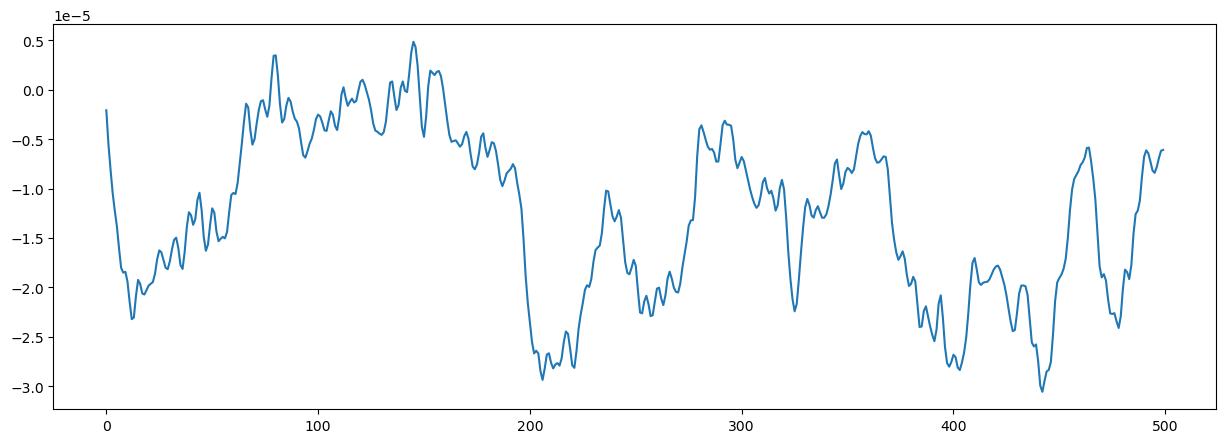

In [25]:
fig, ax = plt.subplots(figsize=[15, 5])
start_time = 15
end_time = 16

ax.plot(raw.get_data(picks="Oz", tmin=start_time, tmax=end_time).T)
plt.show()

### Plot EEG data with MNE

We could add more code to the above cell to do things like label the axes, add a title to indicate what electrode the data came from, make the *x* axis actually represent units of time, etc.. However, the great value of using MNE is that the developers have created customized functions for doing most everything you could ever want with EEG, with a lot less typing than if you were working with raw NumPy arrays and Matplotlib. 

For example, MNE data classes like `Raw` have a `.plot` method that allows you to generate a nice-looking plot that automatically does all the hard work of formatting it appropriately:

~~~python
# Be sure to include the semicolon at the end of the line. We'll learn why later.
raw.plot(start=15, duration=1);  
~~~

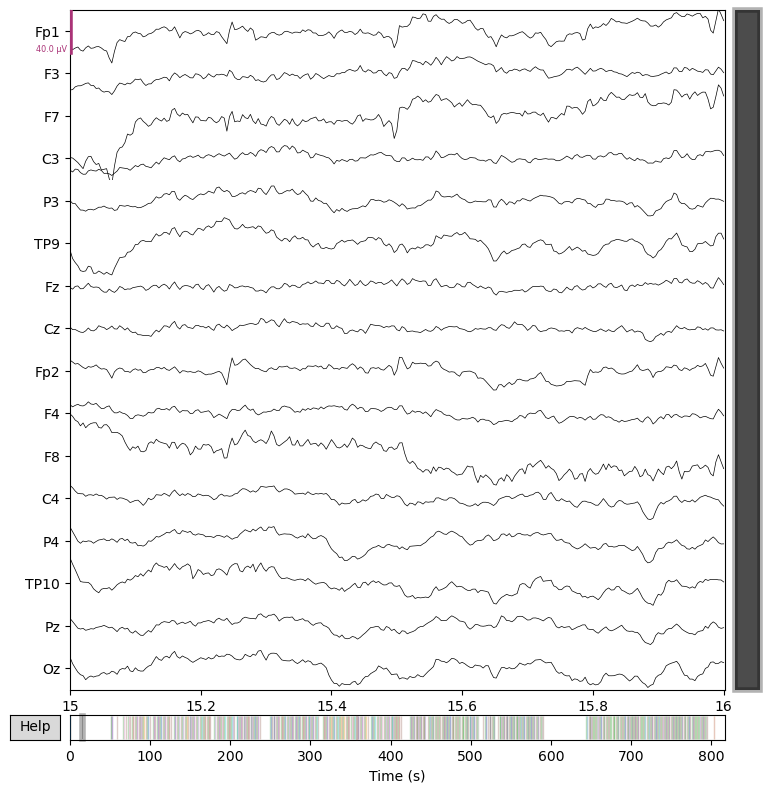

In [26]:
raw.plot(start=15, duration=1);

Note carefully that there are two *x* axes in the plot. The top one (closer to the plot itself) are the time units of the data (in seconds). The bottom axis shows the timeline of the entire raw EEG recording, with a dark vertical bar near the start indicating the position in the file that is currently plotted. Although it doesn't work in web-based Jupyter environments like CoCalc, if you install Python on your own computer and run MNE you will get an interactive plot, that allows you to scroll through the data over time.

## Set electrode positions

One thing that can be useful at this stage is visualizing the electrode positions on the head. Typically, EEG studies try to position electrodes in a fairly evenly-spaced way over the top of the head. However, the locations can depend on what ERP [components](./components) are predicted for the study, and how many electrodes are available. 

MNE provides a `.plot_sensors()` method for visualizing sensor locations. However, by default although our raw data contains the *names* of each channel, it does not contain information regarding where each channel was located. Fortunately, in this and most EEG studies, the electrode positions were based on the International 10-20 system. This was first introduced as a way of standardizing EEG electrode placement in clinical neurology, and is so-named because electrode positions are determined by first measuring the anterior-posterior and left-right dimensions of the participant's head, and then placing electrodes at positions determined by 10 and 20% increments of those measurements (E.g., electrode Cz is placed 50% of the anterior-posterior and left-right measurements). More recently, [Oostenveld and Praamstra (2001)](https://doi.org/10.1016/S1388-2457(00)00527-7) published an extension of this called the 10-5 system, that allows for a larger number of electrodes based on 5% increments. You can read more about this system and its variants on [Oostenveld's blog](https://robertoostenveld.nl/electrode/#oostenveld2001). 

Long story short, we have to first run an MNE method to look up the locations of each electrode based on its 10-20 system name, and set the positions in the raw file. We do this with `.set_montage()`, and as an argument use MNE's built-in list of 10-5 system electrode names and locations.

<div class="alert alert-block alert-info">
    
**Note:** *Montage* is a common word used to describe the arrangement of EEG electrodes on a head, or in an EEG cap. In more general usage, *montage* means "a collection of elements".</div>


~~~python
raw.set_montage('standard_1005')
~~~

In [27]:
raw.set_montage("standard_1005")

Measurement date,"January 20, 2015 13:15:58 GMT"
Experimenter,Unknown
Participant,Unknown
Digitized points,19 points
Good channels,16 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,500.00 Hz
Highpass,0.01 Hz
Lowpass,80.00 Hz


MNE prints out the `info` for the `Raw` object again, and if you compare this output to that from earlier, you'll see that the *Digitized points* field has changed from "Not available" to "19 points". This terminology is a bit strange - "digitized points" seems more general and nonspecific than "electrode locations", for example. The reason for this is that in some cases, researchers will actually use a device to digitize the locations of electrodes when they are on a person's head, rather than relying on standard positions. Anyway, this information is stored under the `dig` attribute, which we can view with:

~~~python
raw.info['dig']
~~~

In [28]:
raw.info["dig"]

[<DigPoint |        LPA : (-82.5, 0.0, 0.0) mm      : head frame>,
 <DigPoint |     Nasion : (-0.0, 114.0, 0.0) mm     : head frame>,
 <DigPoint |        RPA : (82.5, -0.0, -0.0) mm     : head frame>,
 <DigPoint |     EEG #1 : (-30.9, 114.6, 27.9) mm   : head frame>,
 <DigPoint |     EEG #3 : (28.4, 115.3, 27.7) mm    : head frame>,
 <DigPoint |    EEG #16 : (-71.9, 73.1, 25.8) mm    : head frame>,
 <DigPoint |    EEG #18 : (-51.8, 86.7, 78.7) mm    : head frame>,
 <DigPoint |    EEG #20 : (-1.2, 93.3, 102.6) mm    : head frame>,
 <DigPoint |    EEG #22 : (50.3, 87.4, 77.3) mm     : head frame>,
 <DigPoint |    EEG #24 : (71.4, 74.5, 25.1) mm     : head frame>,
 <DigPoint |    EEG #40 : (-67.1, 23.4, 104.5) mm   : head frame>,
 <DigPoint |    EEG #42 : (-1.4, 27.6, 140.2) mm    : head frame>,
 <DigPoint |    EEG #44 : (65.3, 23.6, 103.7) mm    : head frame>,
 <DigPoint |    EEG #48 : (-87.6, -17.6, -3.4) mm   : head frame>,
 <DigPoint |    EEG #58 : (84.2, -18.8, -3.5) mm    : head fra

Each electrode location is stored as a set of (*x*, *y*, *z*) Cartesian coordinates, i.e., positions in a 3D grid, where *x* is the left-right dimension, *y* is posterior-anterior, and *z* is inferior-posterior. The (0, 0, 0) location is inside the head, located in a plane defined by the bridge of the nose (called the **nasion**) and the left and right ear canals. As shown in the figure below, *x* goes from left (negative) to right (positive), *y* goes from posterior to anterior, and *z* goes from inferior to superior. In general, you won't need to work with this coordinate system directly, but it's useful to know how the data are represented.

![cartesian coordinate system for electrode positions](images/MRI_ax_sag_cor.jpg)

Note above as well that the list of sensor locations does not contain the names of each sensor — the channel names we saw above. In general MNE's data structure is designed to assume that channels are listed in the same order in all attributes of the data structure. So, the list of channel names from

~~~python
raw.info['ch_names']
~~~

In [29]:
raw.info["ch_names"]

['Fp1',
 'F3',
 'F7',
 'C3',
 'P3',
 'TP9',
 'Fz',
 'Cz',
 'Fp2',
 'F4',
 'F8',
 'C4',
 'P4',
 'TP10',
 'Pz',
 'Oz']

can be used to label the `EEG` channels in `raw.info['dig']`

### View electrode positions

MNE provides tools for viewing channel locations in both 2D and 3D:

~~~python
raw.plot_sensors()
~~~

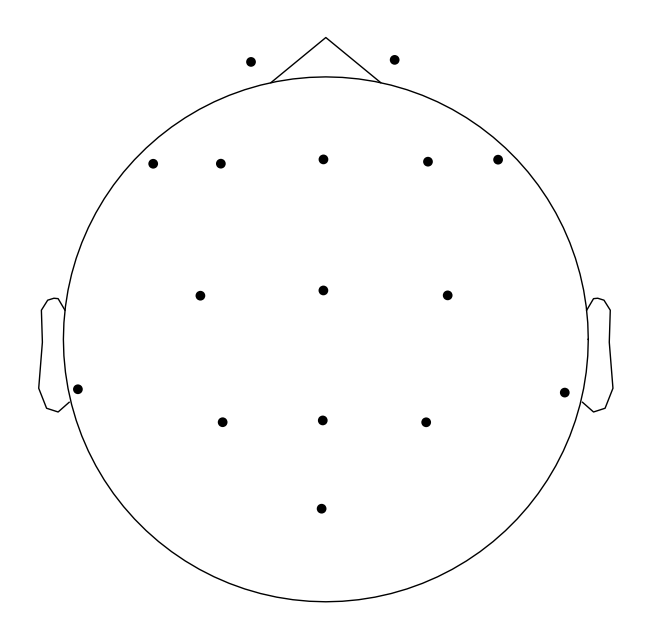

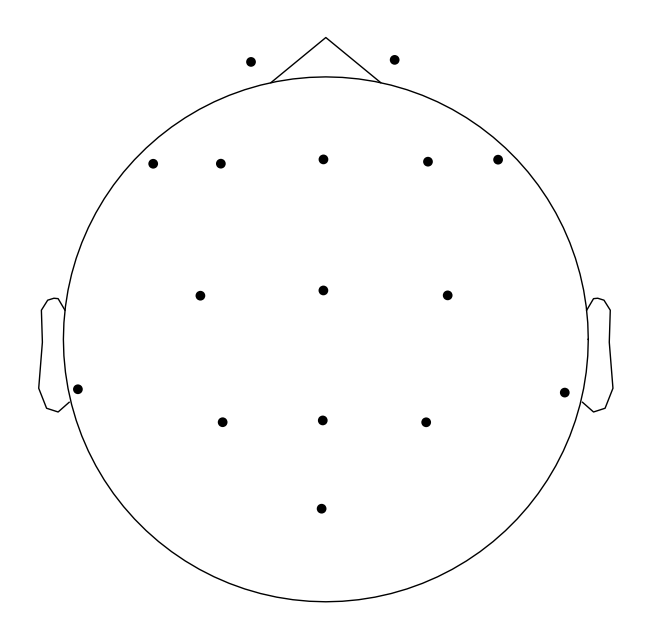

In [30]:
raw.plot_sensors()

## MNE plots in Jupyter notebooks

You'll notice above that MNE actually drew two copies of the figure. This is a default behaviour of MNE for many plots, and it's annoying if you don't know how to deal with it. There are two ways to ensure MNE produces only a single copy of a figure:

### End the plot command with a semicolon


~~~python
raw.plot_sensors();
~~~

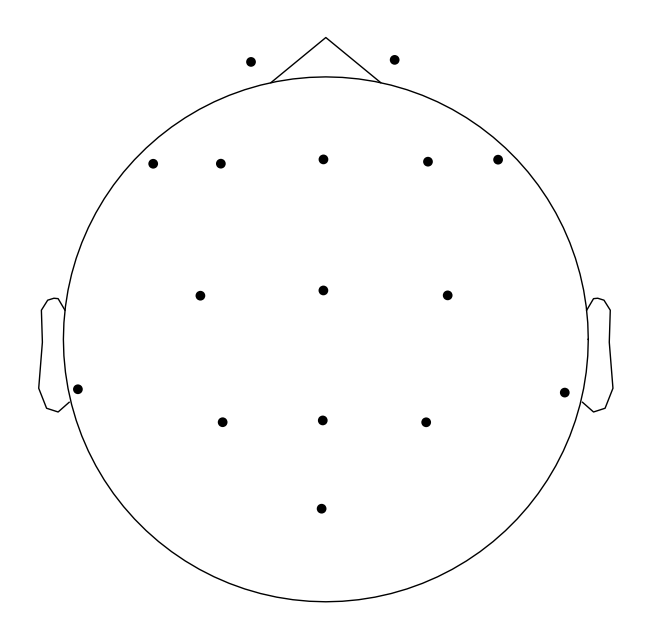

In [31]:
raw.plot_sensors();

### Use `plt.show()` 

...at the bottom of the cell (or at least after all plotting commands in the cell)  

~~~python
raw.plot_sensors()
plt.show()
~~~

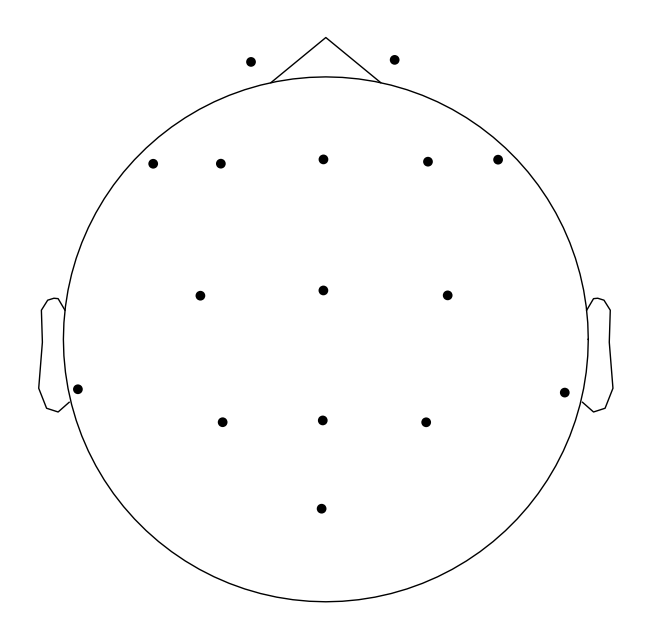

In [32]:
raw.plot_sensors()
plt.show()

### Show sensor names
We can also add a kwarg to show the names of each sensor:

~~~python
raw.plot_sensors(show_names=True)
plt.show()
~~~

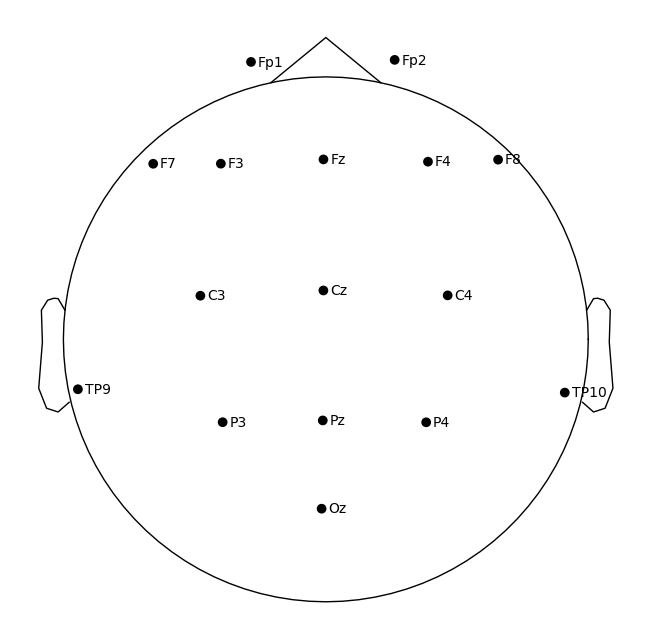

In [33]:
raw.plot_sensors(show_names=True)
plt.show()

## Event codes (markers/triggers)

Yes, there are (at least) three names for the codes that mark events in EEG data! *Markers* makes intuitive sense because they mark the time of events of interest in the EEG data. *Triggers* is a somewhat old-fashioned term; its origin is obscure but perhaps reflects the idea that stimuli "trigger" brain responses that we can measure with EEG. *Event codes* makes sense since they are codes that indicate not only that an event occurred, but it's identity. We'll use *event codes* from this point forward.

As noted earlier, the event codes are stored in the `.trg` file in Brain Vision format. When we import the raw data into MNE, these are stored in an attribute called `._annotations`. Although we can access that directly (e.g., `raw._annotations`), again MNE provides tools that makes this easier and generate more interpretable output: the `events_from_annotations()` function:

~~~python
mne.events_from_annotations(raw)
~~~

In [35]:
mne.events_from_annotations(raw)

(array([[     0,      0,  99999],
        [     0,      0,  10001],
        [ 25550,      0,      5],
        ...,
        [397701,      0,      3],
        [402068,      0,      7],
        [402073,      0,      4]]),
 {'Comment/actiCAP Data On': 10001,
  'New Segment/': 99999,
  'Stimulus/S  1': 1,
  'Stimulus/S  2': 2,
  'Stimulus/S  3': 3,
  'Stimulus/S  4': 4,
  'Stimulus/S  5': 5,
  'Stimulus/S  7': 7,
  'Stimulus/S101': 101,
  'Stimulus/S102': 102,
  'Stimulus/S111': 111,
  'Stimulus/S112': 112,
  'Stimulus/S201': 201,
  'Stimulus/S202': 202,
  'Stimulus/S211': 211,
  'Stimulus/S212': 212})

The result includes two outputs, The first is a NumPy array that has three columns, with one row for each event code in the data. The first column indicates the time of the event (in milliseconds, relative to the start of the recording), and the last column stores the code associated with that event. These event codes are always represented as integers (since it is a NumPy array of integers). 

The second output is a dictionary mapping labels for each event code, to the numerical codes themselves. Usually these are not very informative in the raw data. In the next lesson, we will learn how to map the numerical codes to meaningful labels based on the experimental design. For now, it's simply important to understand how the event codes are stored in the `Raw` data object.